## Introductory Information

### Project Goal - **Segmentation as Clusterization**

**Goal**: Unsupervised segmentation of simple images

1. Train a simple **U-Net** model for supervised segmentation.
2. To extract useful features train an autoencoder U-net model that reconstructs an image.
3. Cluster the intermediate features of the model.
4. Use cluster assignments as weak segments
5. Compare performance at different depths in the model

**Bonus**: Learn weak clusterization (Slot attention)

### Dataset Used

The **CLEVR (with masks)** Dataset

The title of the dataset is **Multi-Object Datasets**, it was published in the year 2019. In this project we use only the **CLEVR (with masks)** subset of data, stored initially in TFRecords format and transformed after into pickle data.

The dataset used can be found at the following <a href="https://github.com/deepmind/multi_object_datasets" target="_blank">GitHub Repository</a>.

The authors consist of the following people:
 * Kabra
 * Rishabh and Burgess
 * Chris and Matthey
 * Loic and Kaufman
 * Raphael Lopez and Greff
 * Klaus and Reynolds
 * Malcolm and Lerchner
 * Alexander

### Dataset Insights

#### Preview Dataset Images

By using only a subpart of the dataset and analysing it we can observe some characteristics such as:

1. The format of the dataset that we used is: **Pickle** because it is easier to work with in the Pytorch environment.
2. The subset contains 7000 images for the training phase and 1000 for testing purposes.
3. There are 3 types of shapes: spheres, cubes and cylinders. They are available in different colors and materials.
4. The number of objects present in an images varies between 1 and 11 (including the background).

Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.


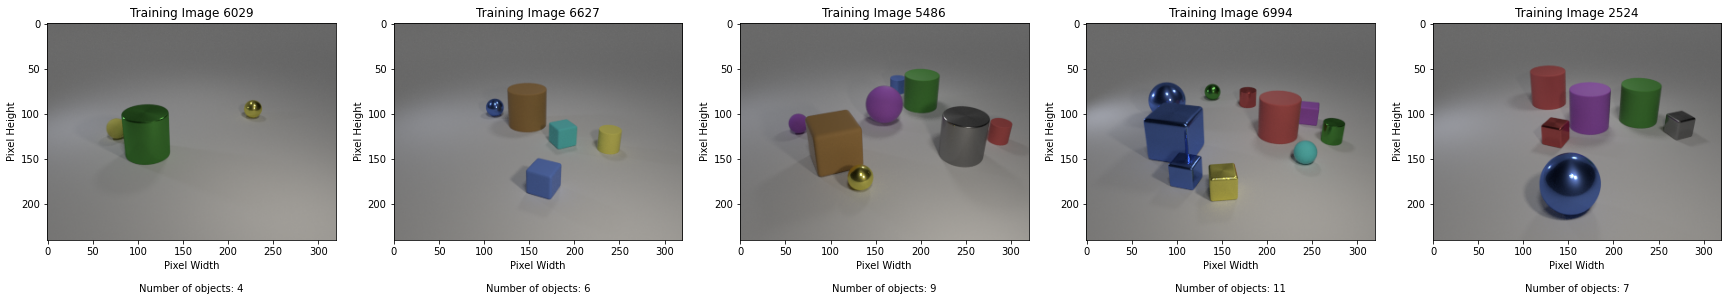

In [1]:
from src.SegmentationDataset import SegmentationDataset
import matplotlib.pyplot as plt
import random

# Define the training dataset
train_dataset = SegmentationDataset(mode='train')

# Create a figure to draw upon
fig = plt.figure()

# Adjust figure properties
fig.set_figwidth(30)
fig.set_figheight(15)

# Preview five random images from the dataset
for idx in range(5):
    # Fetch a random image from the training dataset
    random_image_index = random.randrange(0, len(train_dataset))

    # Extract an image from the dataset
    image, masks, count = train_dataset[random_image_index]

    # Specify a subplot
    plt.subplot(1, 5, idx + 1)

    # Specify the title of the image
    plt.title(f'Training Image {random_image_index}')
    
    # Add additional information in the subplots
    plt.ylabel('Pixel Height')
    plt.xlabel(f'Pixel Width\n\nNumber of objects: {int(count)}')

    # Draw the image on screen
    plt.imshow(image.permute(1, 2, 0))

#### Preview Dataset Masks

Each image in the dataset has an array of **masks** associated with it, which specifies the perfect segmentation of the objects. Take as an example the following image:

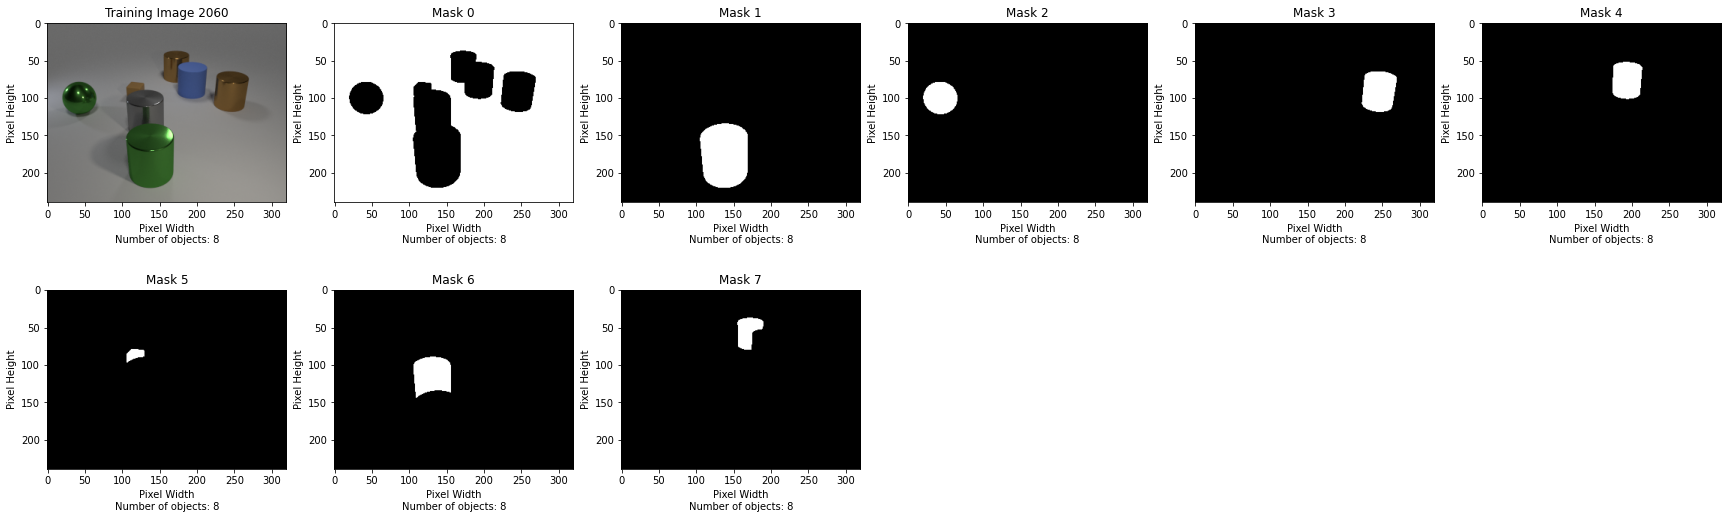

In [2]:
import matplotlib.pyplot as plt
import random

# Fetch a random image from the training dataset
random_image_index = random.randrange(0, len(train_dataset))

# Extract an image from the dataset
image, masks, count = train_dataset[random_image_index]

# Create a figure to draw upon
fig = plt.figure()

# Adjust figure properties
fig.set_figwidth(30)
fig.set_figheight(9)

# Show original image
plt.subplot(2, 6, 1)

# Specify the title of the image
plt.title(f'Training Image {random_image_index}')

# Add additional information in the subplot
plt.ylabel('Pixel Height')
plt.xlabel(f'Pixel Width\nNumber of objects: {int(count)}')

# Draw the orignal image on screen
plt.imshow(image.permute(1, 2, 0))

# Show all masks
for idx, mask in enumerate(masks[:int(count)]):
    # Specify a subplot
    plt.subplot(2, 6, idx + 2)

    # Specify the title of the image
    plt.title(f'Mask {idx}')

    # Add additional information in the subplot
    plt.ylabel('Pixel Height')
    plt.xlabel(f'Pixel Width\nNumber of objects: {int(count)}')
    
    # Draw the image on screen
    plt.imshow(mask.repeat(3, 1, 1).permute(1, 2, 0))

#### Calculate the Percentages of Gray and Non-Gray Pixels in Images

In [3]:
from src.SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from src.Config.Args import args
from src.Process import gray_map

# Define the training dataset and loader
train_dataset = SegmentationDataset(mode='train')
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

# Count the total amount of gray pixels and non-gray pixels
total_non_gray_samples = 0
total_gray_samples = 0

for (images, masks, clusters) in train_loader:
    # Calculate the number of gray samples
    gray_samples = gray_map(images).sum()

    # Add the gray samples to the total count
    total_gray_samples += gray_samples

    # Calculate the number of non-gray samples
    non_gray_samples = images.numel() // 3 - gray_samples

    # Add the non-gray samples to the total count
    total_non_gray_samples += non_gray_samples

# Calculate gray and non-gray weights
old_non_gray_weight = 1. / total_non_gray_samples
old_gray_weight = 1. / total_gray_samples

# Normalize the values
non_gray_weight = old_non_gray_weight / (old_non_gray_weight + old_gray_weight)
gray_weight = old_gray_weight / (old_non_gray_weight + old_gray_weight)

# Print the percentages for gray and non-gray pixels
print(f'Non-Gray Pixels: {100. * non_gray_weight:.02f}%')
print(f'Gray Pixels: {100. * gray_weight:.02f}%')

Loaded ./data/input/train_test_clevr_pkls/train_clevr_2000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_4000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_7000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_1000.pkl in memory.
Non-Gray Pixels: 72.76%
Gray Pixels: 27.24%


## Create **Dataset** and **DataLoaders** to facilitate the training process

In [4]:
from src.SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from src.Config.Args import args

# Define the datasets for both training and testing
test_dataset = SegmentationDataset(mode='test')
train_dataset = SegmentationDataset(mode='train')

# Define the dataloaders for both training and testing
test_loader = DataLoader(test_dataset, args.test_batch_size, args.shuffle)
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

## Training Unsupervised Models on the **CLEVR (with masks)** Dataset

### Specify the Model Type

In [5]:
from src.Utils import make_model

# Load the custom 'UNet' or 'AutoEncoder' model for 'rgb' or 'grayscale' images
model_type, model_weights_path, transform = make_model(name='UNet', image_type='rgb')

### Instantiate the Model

In [7]:
import torch

# Instantiate the model and send it to the GPU
model = model_type(n_filters=args.n_filters).to(args.device)

# Define a custom optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learn_rate, weight_decay=args.weight_decay)

# Specify a custom loss function
criterion = torch.nn.MSELoss()

### Train the Model

In [ ]:
from src.Process import make_grayscale, process
from src.Plotter import plot_loss
from src.Train import train
import torch

# Retain the loss evolution
losses_train = []

# Train the model for a number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    train_loss = train(model, train_loader, optimizer, criterion, epoch, transform)

    # Retain the current loss
    losses_train.append(train_loss)

    # Separate the outputs
    print()

# Plot the loss evolution
plot_loss(losses_train, 'train_loss', 'Train Loss', 'Epoch', 'Loss')

The model should also be saved on disk to avoid future reprocessing.

In [8]:
# Save the weights on disk
torch.save(model.state_dict(), model_weights_path)

### Load the Model

In [9]:
from src.Model.UNet.UNetCNN import UNetCNN
import torch

# Instantiate the model and send it to the GPU
model = model_type(n_filters=args.n_filters).to(args.device)

# Load the model trained parameters in memory
model.load_state_dict(torch.load(model_weights_path))

<All keys matched successfully>

### Preview Some Outputs on the Test Dataset

Loaded ./data/input/train_test_clevr_pkls/test_clevr_8000.pkl in memory.


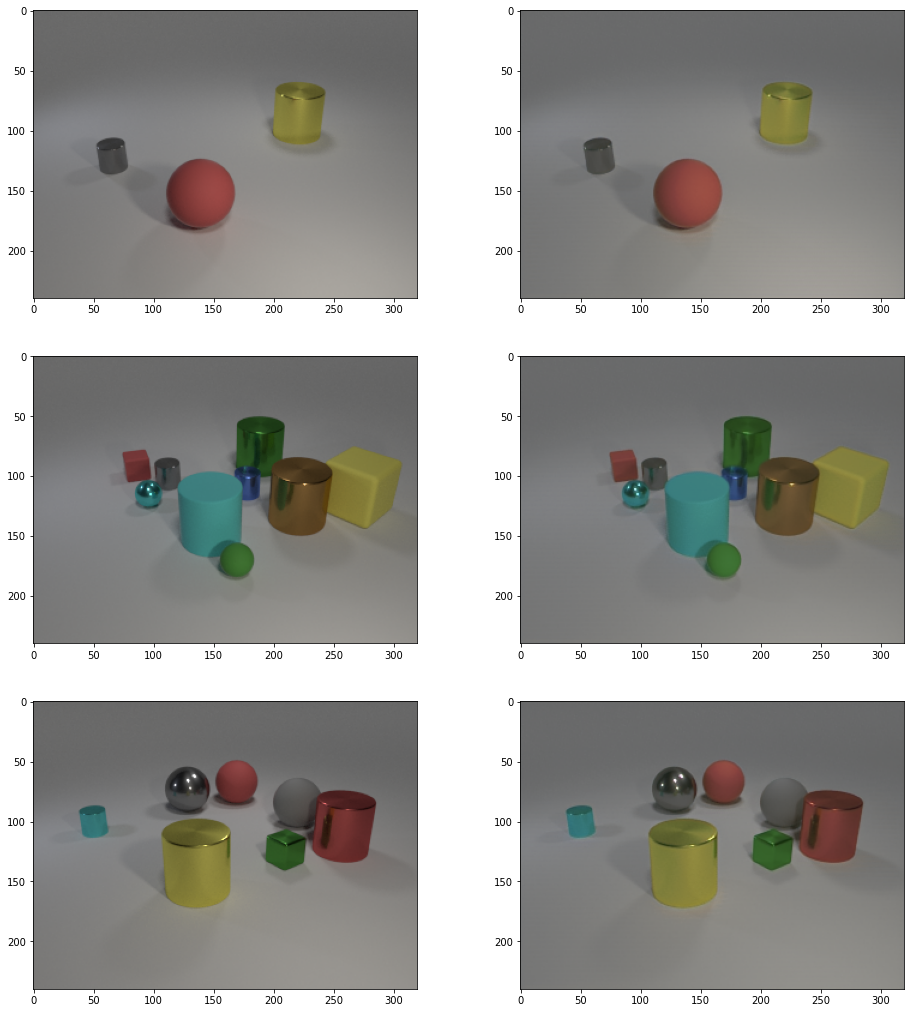

In [10]:
from src.Process import unprocess, process, make_grayscale
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a new figure
f = plt.figure()
f.set_figheight(18)
f.set_figwidth(16)

# Set the number of samples
current_subplot = 1
total_subplots = 3

for batch_idx, (images, masks, counts) in enumerate(test_loader):
    if batch_idx == total_subplots:
        break

    # Specify the input image
    img_true = images[0]

    # Calculate the predicted image and transform it from [0, 1] -> [0, 255]
    img_pred = unprocess(model(transform(img_true.unsqueeze(0).to(args.device)))).cpu()
    
    # Plot input image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_true.permute(1, 2, 0))
    current_subplot += 1

    # Plot output image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_pred.squeeze(0).permute(1, 2, 0))
    current_subplot += 1

# Plot the images
plt.show()

Size of image: torch.Size([76800, 3])
Object count: 11


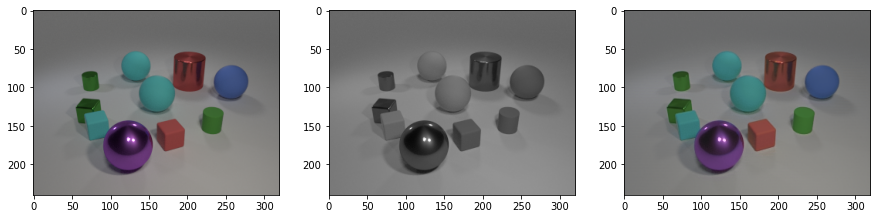

In [11]:
from src.Process import process
import random

# Fetch entry
index = int(random.uniform(0, 1000))
image, mask, count = test_dataset[index]

# Store original image
original = image.clone()

# Store the processed image
proc_img = make_grayscale(image.unsqueeze(0)).squeeze(0)

# Pass through model
out_img = unprocess(model(transform(image.unsqueeze(0).to(args.device)))).squeeze(0)

# Reshape image
image = out_img.permute(1, 2, 0).to(torch.float)
image = image.reshape(-1, image.shape[2])

# Format object count
count = count.to(torch.int).item()

# Set figure properties
f = plt.figure()
f.set_figheight(20)
f.set_figwidth(15)

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(original.permute(1, 2, 0))
print(f'Size of image: {image.shape}')
print(f'Object count: {count}')

# Show grayscale image
plt.subplot(1, 3, 2)
plt.imshow(proc_img.permute(1, 2, 0))

# Show grayscale image
plt.subplot(1, 3, 3)
plt.imshow(out_img.cpu().permute(1, 2, 0))

K-means for the cosine similarity with 76,800 points in dimension 3, K = 11:
K-means for the cosine similarity with 76,800 points in dimension 8, K = 11:
K-means for the cosine similarity with 19,200 points in dimension 16, K = 11:
K-means for the cosine similarity with 4,800 points in dimension 32, K = 11:
K-means for the cosine similarity with 1,200 points in dimension 64, K = 11:
K-means for the cosine similarity with 300 points in dimension 128, K = 11:
K-means for the cosine similarity with 1,200 points in dimension 64, K = 11:
K-means for the cosine similarity with 4,800 points in dimension 32, K = 11:
K-means for the cosine similarity with 19,200 points in dimension 16, K = 11:
K-means for the cosine similarity with 76,800 points in dimension 8, K = 11:
K-means for the cosine similarity with 76,800 points in dimension 3, K = 11:


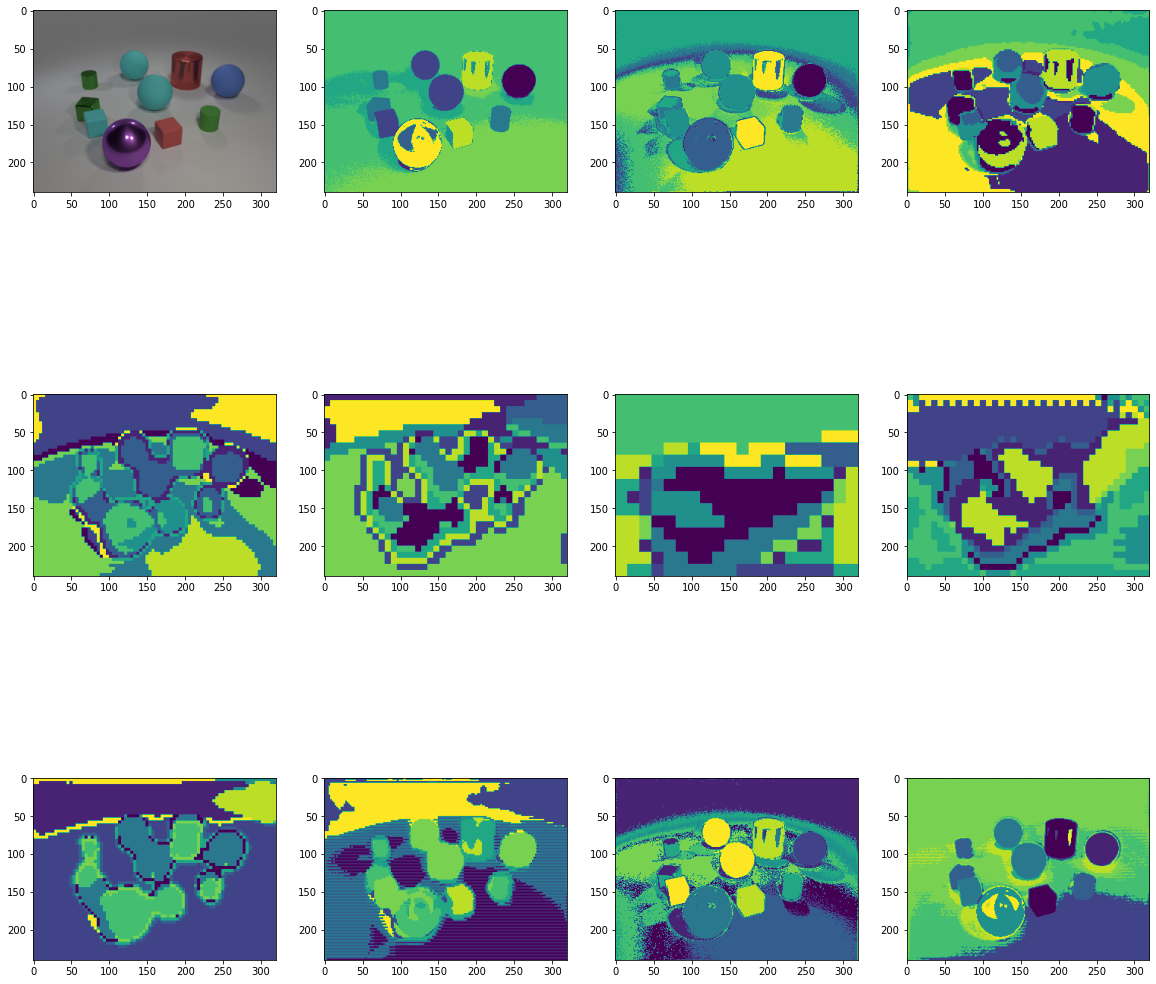

In [13]:
from src.KMeans import KMeans_cosine

# Create a new figure
fig = plt.figure()

# Set the properties of the figure
fig.set_figwidth(20)
fig.set_figheight(20)

# Plot initial image
plt.subplot(3, 4, 1)
plt.imshow(model.feature_maps[0].squeeze(0).permute(1, 2, 0).cpu())

for idx, hmap in enumerate(model.feature_maps):
    # Define the custom upsampler
    up = torch.nn.Upsample(scale_factor=240 / hmap.shape[2], mode='nearest')

    # Get the initial sizes
    N, C, H, W = hmap.shape

    # Send the data to the device
    hmap = hmap.to(args.device)

    # Permute the dimensions
    hmap = hmap.squeeze(0).permute(1, 2, 0)
    
    # Concat pixels
    hmap = hmap.reshape((-1, hmap.shape[2]))

    # Make the memory contiguous
    hmap = hmap.contiguous()

    # Run the K-Means algorithm
    labels, clusters = KMeans_cosine(hmap, K=count, n_init=10, max_iter=300, tol=1e-5)

    # Select current subplot
    plt.subplot(3, 4, idx + 2)

    # Reshape the labels to the initial size: (H, W)
    labels = labels.reshape((H, W))

    # Add additional dimensions for upsampling
    labels = labels.unsqueeze(0).unsqueeze(0)

    # Upsample the labels
    labels = up(labels.float())
    
    # Plot the resulting image
    plt.imshow(labels.cpu().squeeze(0).squeeze(0))

plt.show()

## Training a Supervised Model on the **CLEVR (with masks)** Dataset